# 2008 Financial Crisis

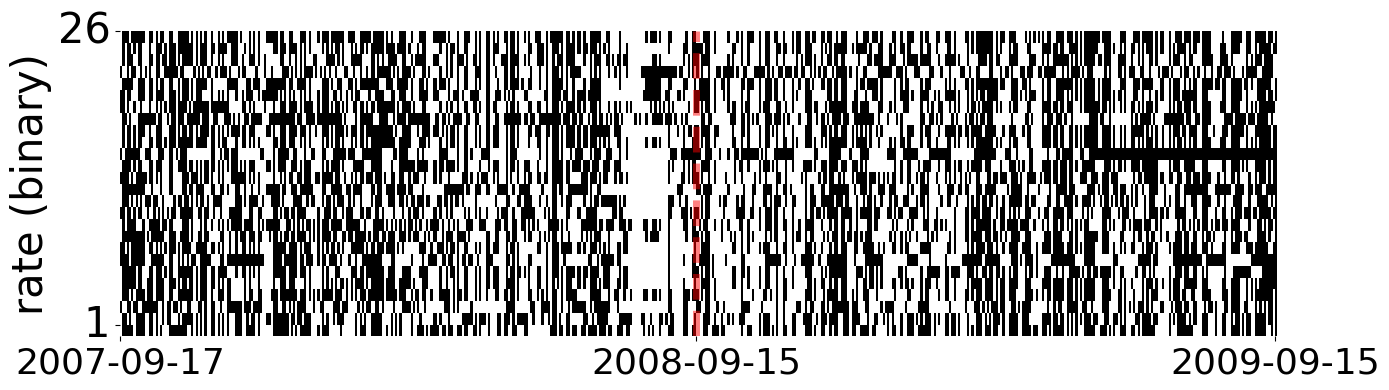

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
data_matrix = pd.read_csv('Results/data_matrix_DKK.csv')

# Convert the date column to datetime for easier handling
data_matrix['Date'] = pd.to_datetime(data_matrix['Date'])

# Focus on the period around the 2008 financial crisis
crisis_start = '2007-09-17'
crisis_end = '2009-09-15'

# Focusing on the crisis period
crisis_data = data_matrix[(data_matrix['Date'] >= crisis_start) & (data_matrix['Date'] <= crisis_end)]

# Set the 'Date' column as the index
crisis_data.set_index('Date', inplace=True)

# Plotting the data
plt.figure(figsize=(14, 4))
ax = sns.heatmap(crisis_data.T, cmap='binary', cbar=False) # White is -1

# Formatting the x-axis to show dates
# ax.set_xticks(range(0, len(crisis_data.index), 22))  # Set x-ticks every 22 days
# ax.set_xticklabels([date.strftime('%Y-%m') for date in crisis_data.index[::22]], rotation=45, fontsize=16)

ax.set_xlabel('')
ax.set_yticks([25, 0])
ax.set_yticklabels(['1', '26'], fontsize=30)
ax.set_ylabel('rate (binary)', fontsize=30)

# Set the x-ticks to show only three specific dates
specific_dates = pd.to_datetime([crisis_start, '2008-09-15', crisis_end])
positions = [crisis_data.index.get_loc(date) for date in specific_dates]

ax.set_xticks(positions)
ax.set_xticklabels([date.strftime('%Y-%m-%d') for date in specific_dates], rotation=0, fontsize=26)

# Drawing a dashed vertical line on 2008-09-15
crisis_line_position = crisis_data.index.get_loc('2008-09-15')
plt.axvline(x=crisis_line_position, color='red', linestyle='--', linewidth=5, alpha=0.5)

plt.tight_layout()
# plt.savefig("Images/binary_representation.svg", format="svg", bbox_inches='tight')
plt.show()

# Metropolis

https://dpotoyan.github.io/Statmech4ChemBio/6_ising/01_MCMC.html

https://towardsdatascience.com/understanding-autocorrelation-in-time-series-analysis-322ad52f2199?gi=57dc8cef4f63

$$\frac{P(i \to f)}{P(f \to i)} = \frac{p_i}{p_f} = e^{-\beta (E_f-E_i)}$$

In [7]:
from numba import njit
import numpy as np
import pandas as pd
from Utility.IsingOptimiserReturn import IsingOptimiser
import matplotlib.pyplot as plt

@njit
def run_ising(spins, J, h, T, n_steps, out_freq=10):
    N = len(spins)
    M = np.sum(spins)

    S, m = [], []
    for step in range(n_steps):
        i = np.random.randint(N)
        dE = 2 * spins[i] * (J[i, :] @ spins + h[i])

        # Metropolis condition
        if dE < 0 or np.random.rand() < np.exp(-dE / T):
            spins[i] *= -1 
            M += 2 * spins[i]

        # Save Thermo data
        if step % out_freq == 0:
            m.append(M/N)
            S.append(spins.copy())

    return S, m

In [8]:
data = pd.read_csv('Results/data_matrix_DKK.csv')
dates_labels = [
    ('2019-03-08', '2020-03-06', "Stablest"),
    ('2017-05-31', '2018-05-29', "Stable"),
    ('2011-05-06', '2012-05-03', "Euro Dept Crisis"),
    ('2008-09-17', '2009-09-15', "Great Recession")
]

In [10]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]

def T_steps(T, base_steps=1000000):
    return int(base_steps*(1/T**2)**np.exp(1/T))

out = 100
base_steps = out * 100
for start_date, end_date, label in dates_labels:
    ising_optimiser = IsingOptimiser(data, start_date, end_date)
    initial_state, J, h = ising_optimiser.train(100)
    initial_state, J, h = initial_state.astype(np.float32), J.astype(np.float32), h.astype(np.float32)

    S1, m1 = run_ising(initial_state, J, h, T=0.5, n_steps=T_steps(0.5, base_steps), out_freq=out)
    S2, m2 = run_ising(initial_state, J, h, T=1, n_steps=T_steps(1, base_steps), out_freq=out)
    S3, m3 = run_ising(initial_state, J, h, T=1.5, n_steps=T_steps(1.5, base_steps), out_freq=out)
    # np.array(S).shape, np.array(m).shape

    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(10,3))

    ax[0].plot(autocorr(m1)/autocorr(m1)[0])
    ax[1].plot(autocorr(m2)/autocorr(m2)[0])
    ax[2].plot(autocorr(m3)/autocorr(m3)[0])
    # plt.xlabel('Steps, $n$')
    # plt.ylabel(r'$\langle m(t)m(t+n) \rangle$')
    fig.tight_layout()
    plt.show()

Optimisation completed with averaged results after 10 successes with 10 attempts.



# Inferring Criticality

In [ ]:
from numba import njit
import numpy as np
import pandas as pd
from Utility.IsingOptimiserReturn import IsingOptimiser
import matplotlib.pyplot as plt

@njit
def run_ising(spins, J, h, T, n_steps=20000, out_freq=10):
    N = len(spins)
    M = np.sum(spins)

    S, m = [], []
    for step in range(n_steps):
        i = np.random.randint(N)
        dE = 2 * spins[i] * (J[i, :] @ spins + h[i])

        # Metropolis condition
        if dE < 0 or np.random.rand() < np.exp(-dE / T):
            spins[i] *= -1 
            M += 2 * spins[i]

        # Save Thermo data
        if step % out_freq == 0:
            m.append(np.abs(M/N))
            S.append(spins.copy())

    return S, m

def get_Xi(M, T):
    return np.var(M)/T

data = pd.read_csv('Results/data_matrix_DKK.csv')
dates_labels = [
    ('2019-03-08', '2020-03-06', "Stablest"),
    ('2017-05-31', '2018-05-29', "Stable"),
    ('2011-05-06', '2012-05-03', "Euro Dept Crisis"),
    ('2008-09-17', '2009-09-15', "Great Recession")
]

T_low, T_high, T_step = 0.5, 1.5, 0.025
Ts = np.arange(T_low, T_high + T_step, T_step)
out = 10

ms, chis, labels = [], [], []

for start_date, end_date, label in dates_labels:
    ising_optimiser = IsingOptimiser(data, start_date, end_date)
    initial_state, J, h = ising_optimiser.train(100)
    initial_state, J, h = initial_state.astype(np.float32), J.astype(np.float32), h.astype(np.float32)

    Ms, Xs = [], [] 

    for T in Ts:
        n_equil = T_steps(T)
        S, m = run_ising(initial_state, J, h, T=T, n_steps=n_equil, out_freq=out)    
        m = m[len(m)//out:]
        Ms.append(np.mean(m))
        Xs.append(get_Xi(m, T))

    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,3))

    ax[0].scatter(Ts, Ms)
    ax[0].set(ylabel='$|m|(T)$')

    ax[1].scatter(Ts, Xs)
    ax[1].set(ylabel=r'$\chi(T)$')
    fig.tight_layout()
    plt.show()

    # Collect data for plotting
    ms.append(Ms)
    chis.append(Xs)
    labels.append(label)

In [ ]:
from matplotlib.lines import Line2D

def plot_all(order_params, susceptibilities, labels, fig_label=None, save=False):
    _, ax1 = plt.subplots(figsize=(12, 12))

    # Set up the color scheme for multiple periods
    colors = ['C0', 'C2', 'C1', 'C3']
    marker_size_m = 10
    marker_size_x = 15
    
    # First y-axis for magnetisation
    color_1 = 'tab:red'
    ax1.set_xlabel(r'$T$', fontsize=30)
    ax1.set_ylabel(f'${fig_label}$', color=color_1, fontsize=30)
    ax1.tick_params(axis='x', labelsize=24)
    ax1.tick_params(axis='y', labelcolor=color_1, labelsize=24)
    ax1.grid(True)
    
    lines = []
    for i, label in enumerate(labels):
        line, = ax1.plot(T_range, order_params[i], 'o-', color=colors[i], label=rf'${fig_label}$ - {label}')
        lines.append(line)
    
    # Second y-axis for susceptibility
    color_2 = 'tab:blue'
    ax2 = ax1.twinx()
    ax2.set_ylabel(r'$\chi$', color=color_2, fontsize=30)
    ax2.tick_params(axis='y', labelcolor=color_2, labelsize=24)

    peak_temps = []
    for i, label in enumerate(labels):
        line, = ax2.plot(T_range, susceptibilities[i], 'x--', color=colors[i], label=rf'$\chi$ - {label}')
        lines.append(line)
        peak_index = np.argmax(susceptibilities[i])
        peak_T = T_range[peak_index]
        peak_temps.append(f'$T_c$: {peak_T:.3f}')
    
    # Custom legend handles
    custom_lines = [Line2D([0], [0], color='C0', lw=4, linestyle='-', marker='o', markersize=marker_size_m),
                    Line2D([0], [0], color='C2', lw=4, linestyle='-', marker='o', markersize=marker_size_m),
                    Line2D([0], [0], color='C1', lw=4, linestyle='-', marker='o', markersize=marker_size_m),
                    Line2D([0], [0], color='C3', lw=4, linestyle='-', marker='o', markersize=marker_size_m),
                    Line2D([0], [0], color='C0', lw=4, linestyle='--', marker='x', markersize=marker_size_x),
                    Line2D([0], [0], color='C2', lw=4, linestyle='--', marker='x', markersize=marker_size_x),
                    Line2D([0], [0], color='C1', lw=4, linestyle='--', marker='x', markersize=marker_size_x),
                    Line2D([0], [0], color='C3', lw=4, linestyle='--', marker='x', markersize=marker_size_x)]
    
    # Position the legend outside with custom handles
    ax1.legend(custom_lines, [rf'${fig_label}$ - {label}' for label in labels] + [rf'$\chi$ - {label}' for label in labels], loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2, fontsize=30)

    # Internal legend for peak temperatures
    ax2.legend(peak_temps, loc='upper right', fontsize=30)

    plt.xlim(T_low, T_high)
    if save == True:
        plt.savefig(f"Images/observables_{fig_label}.svg", format="svg", bbox_inches='tight')
    plt.show()

T_range = np.arange(T_low, T_high + T_step, T_step)
plot_all(ms, chis, labels, '|m|', True)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(J, h):
    # Prepare the coupling matrix J by inserting h into its diagonal
    np.fill_diagonal(J, h)

    # Plotting heatmaps for optimised parameters
    plt.figure(figsize=(12, 10))

    # heatmap plot for J
    ax = sns.heatmap(J, annot=False, fmt='.2f', annot_kws={"size": 20}, cmap='Spectral', center=0)  # Create the heatmap with annotations

    # Increase the font size of the colorbar tick labels
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=30)  # Adjust font size as needed

    # Remove the ticks
    plt.xticks([])
    plt.yticks([])

    # Display the heatmap
    plt.tight_layout()
    plt.savefig("Images/J_heatmap.png", format="png", bbox_inches='tight')
    plt.show()

# J = pd.read_csv('Results/J.csv').values
# h = pd.read_csv('Results/h.csv', header=None)[1].values
# 
# expanded_J, expanded_h = expand_data(10, J, h, 'johnsonsu')
# plot_heatmap(expanded_J, expanded_h)